In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [2]:
from pathlib import Path
import requests

In [3]:
csvpath = Path("CAT_nasdaqdata.csv")

In [4]:
df = pd.read_csv(csvpath, index_col='Date', infer_datetime_format=True, parse_dates=True)

In [5]:
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-07-06,$213.52,4348120,$217.41,$217.56,$211.34
2021-07-02,$217.76,2434363,$217.66,$218.37,$215.58
2021-07-01,$216.71,2426331,$219.16,$219.79,$216.15
2021-06-30,$217.63,3249543,$214.62,$217.95,$214.06
2021-06-29,$215.10,3443372,$218.04,$218.70,$214.59


In [6]:
df.sort_index(ascending=True, inplace=True)

In [7]:
df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
df['Open'] = df['Open'].str.replace('$', '').astype(float)
df['High'] = df['High'].str.replace('$', '').astype(float)
df['Low'] = df['Low'].str.replace('$', '').astype(float)

<ipython-input-7-0b04cfc5e4f7>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Close/Last'] = df['Close/Last'].str.replace('$', '').astype(float)
<ipython-input-7-0b04cfc5e4f7>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['Open'] = df['Open'].str.replace('$', '').astype(float)
<ipython-input-7-0b04cfc5e4f7>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['High'] = df['High'].str.replace('$', '').astype(float)
<ipython-input-7-0b04cfc5e4f7>:4: FutureWarning: The default value of regex will change from True to

In [8]:
df

,Close/Last,Volume,Open,High,Low
Date,,,,,
2011-07-06,110.08,6926258,108.11,110.12,108.08
2011-07-07,111.63,7387721,111.57,112.65,111.25
2011-07-08,110.41,8278942,108.52,110.41,107.80
2011-07-11,108.16,7547448,108.41,109.48,107.25
2011-07-12,106.93,7883829,107.63,108.46,106.67
...,...,...,...,...,...
2021-06-29,215.10,3443372,218.04,218.70,214.59
2021-06-30,217.63,3249543,214.62,217.95,214.06
2021-07-01,216.71,2426331,219.16,219.79,216.15


In [9]:
df = df.reset_index()

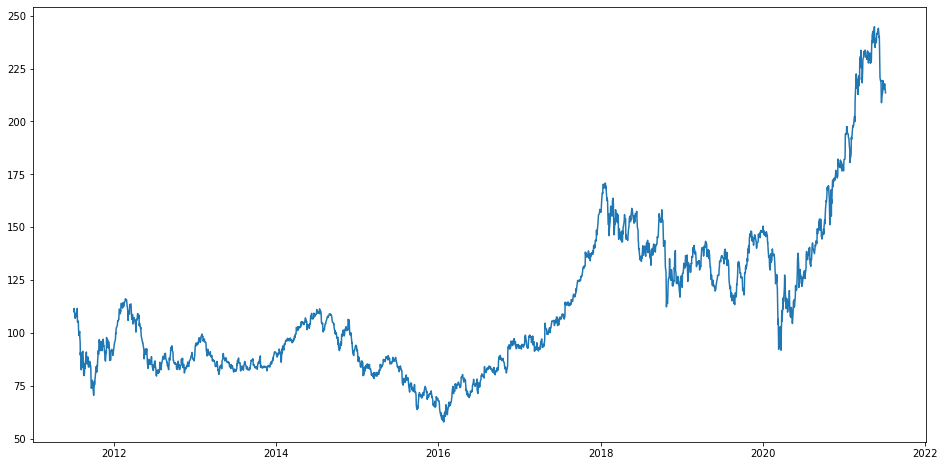

In [10]:
df['Date'] = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close/Last"],label='Close Price history')

In [11]:
data = df.sort_index(ascending=True,axis=0)

In [12]:
new_dataset = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close/Last'])

for i in range(0,len(data)):
    new_dataset["Date"][i] = data['Date'][i]
    new_dataset["Close/Last"][i] = data["Close/Last"][i]

In [13]:
new_dataset = new_dataset.set_index('Date')

In [14]:
new_dataset

,Close/Last
Date,
2011-07-06,110.08
2011-07-07,111.63
2011-07-08,110.41
2011-07-11,108.16
2011-07-12,106.93
...,...
2021-06-29,215.1
2021-06-30,217.63
2021-07-01,216.71


In [15]:
#new_dataset['Close/Last'] = new_dataset['Close/Last'].str.replace('$', '').astype(float)

In [16]:
new_dataset

,Close/Last
Date,
2011-07-06,110.08
2011-07-07,111.63
2011-07-08,110.41
2011-07-11,108.16
2011-07-12,106.93
...,...
2021-06-29,215.1
2021-06-30,217.63
2021-07-01,216.71


In [17]:
scaler = MinMaxScaler(feature_range=(0,1))
final_dataset = new_dataset.to_numpy()

train_data = final_dataset[0:987,:]
valid_data = final_dataset[987:,:]


#new_dataset.drop(["Date"],axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

x_train_data,y_train_data = [],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data = np.array(x_train_data),np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [18]:
lstm_model = Sequential()

lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [19]:
inputs_data = new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 4s - loss: 5.5967e-04


In [20]:
X_test = []
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

In [21]:
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [22]:
lstm_model.save("saved_model.h5")

In [23]:
train_data = new_dataset[:987]
valid_data = new_dataset[987:]

In [24]:
valid_data

,Close/Last
Date,
2015-06-09,86.73
2015-06-10,88.48
2015-06-11,88.17
2015-06-12,87.85
2015-06-15,87.13
...,...
2021-06-29,215.1
2021-06-30,217.63
2021-07-01,216.71


In [25]:
predicted_closing_price

array([[ 87.67022 ],
       [ 83.622475],
       [ 76.49763 ],
       [ 72.49545 ],
       [ 72.18057 ],
       [ 61.847836],
       [ 74.147865],
       [ 80.54435 ],
       [ 78.16091 ],
       [ 83.02476 ],
       [ 83.70903 ],
       [ 87.347244],
       [ 97.75917 ],
       [ 98.70346 ],
       [ 94.31718 ],
       [104.088036],
       [108.41952 ],
       [116.38855 ],
       [124.712074],
       [142.10132 ],
       [153.73532 ],
       [168.0463  ],
       [159.42836 ],
       [152.68307 ],
       [149.37527 ],
       [145.45355 ],
       [160.4118  ],
       [128.82579 ],
       [125.23924 ],
       [134.55145 ],
       [137.64342 ],
       [132.7359  ],
       [140.97835 ],
       [119.681206],
       [129.24731 ],
       [153.27196 ],
       [155.31801 ],
       [142.45644 ],
       [116.35492 ],
       [112.886055],
       [130.45415 ],
       [144.80222 ],
       [156.488   ],
       [183.75381 ],
       [200.24763 ],
       [234.95433 ],
       [255.10312 ],
       [263.7

In [26]:
#valid_data['Predictions'] = predicted_closing_price

#predicted = pd.DataFrame(predicted_closing_price)

In [27]:
import datetime

In [28]:
# %Y-%m-%d

dates = pd.date_range("2021-07-07", periods=48, freq="D")
dates

DatetimeIndex(['2021-07-07', '2021-07-08', '2021-07-09', '2021-07-10',
               '2021-07-11', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-17', '2021-07-18',
               '2021-07-19', '2021-07-20', '2021-07-21', '2021-07-22',
               '2021-07-23', '2021-07-24', '2021-07-25', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-07-31', '2021-08-01', '2021-08-02', '2021-08-03',
               '2021-08-04', '2021-08-05', '2021-08-06', '2021-08-07',
               '2021-08-08', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-14', '2021-08-15',
               '2021-08-16', '2021-08-17', '2021-08-18', '2021-08-19',
               '2021-08-20', '2021-08-21', '2021-08-22', '2021-08-23'],
              dtype='datetime64[ns]', freq='D')

In [29]:
predicted = pd.DataFrame(predicted_closing_price, index=dates)
predicted

,0
2021-07-07,87.670219
2021-07-08,83.622475
2021-07-09,76.497627
2021-07-10,72.495453
2021-07-11,72.180573
2021-07-12,61.847836
2021-07-13,74.147865
2021-07-14,80.544350
2021-07-15,78.160912
2021-07-16,83.024757


In [30]:
predicted.rename(columns={0: "Predictions"}, inplace=True)

In [31]:
predicted.head()

,Predictions
2021-07-07,87.670219
2021-07-08,83.622475
2021-07-09,76.497627
2021-07-10,72.495453
2021-07-11,72.180573


In [32]:
final_frames = [valid_data, predicted]

valid_data = pd.concat(final_frames, axis=0, join="outer")
valid_data

,Close/Last,Predictions
2015-06-09,86.73,NaN
2015-06-10,88.48,NaN
2015-06-11,88.17,NaN
2015-06-12,87.85,NaN
2015-06-15,87.13,NaN
...,...,...
2021-08-19,NaN,183.753815
2021-08-20,NaN,200.247635
2021-08-21,NaN,234.954330
2021-08-22,NaN,255.103119


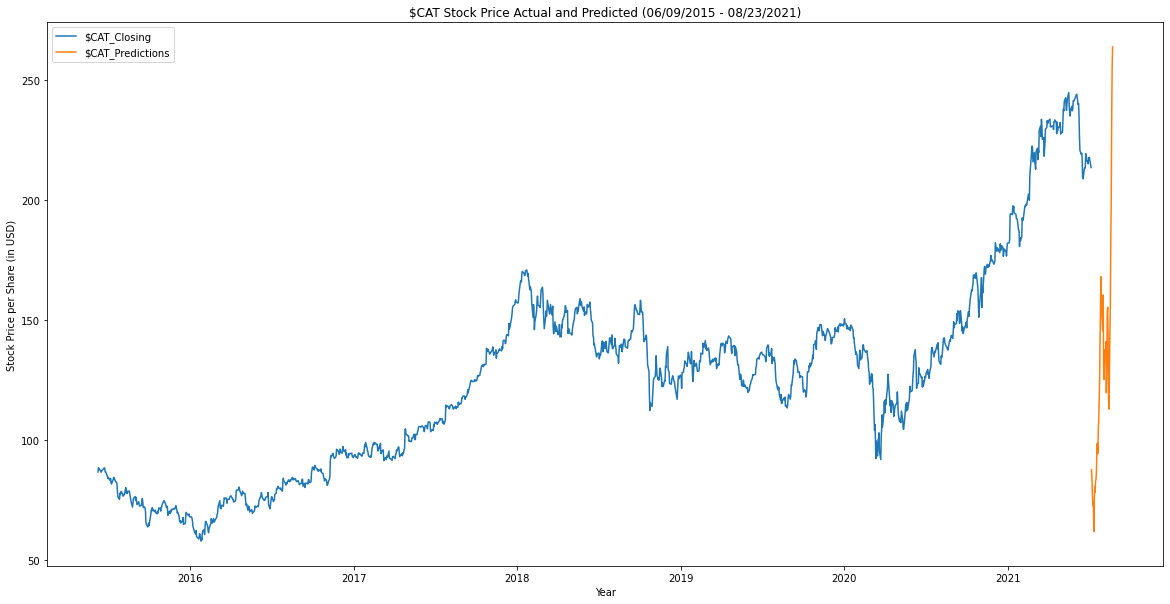

In [33]:
plt.plot(valid_data['Close/Last'], label="$CAT_Closing")
plt.plot(valid_data['Predictions'], label="$CAT_Predictions")
plt.title('$CAT Stock Price Actual and Predicted (06/09/2015 - 08/23/2021)')
plt.xlabel('Year')
plt.ylabel('Stock Price per Share (in USD)')
plt.legend(loc="best")
plt.show()